In [1]:
import numpy as np
from landlab import RasterModelGrid, imshow_grid
from landlab.components import FlowAccumulator, FastscapeEroder, DepressionFinderAndRouter, SinkFillerBarnes, LakeMapperBarnes
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import RandomState

In [ ]:
nr = 201
nc = 201
dx = 1.
mg = RasterModelGrid((nr, nc), xy_spacing = dx)

z = np.ones(nr*nc) * 100 + mg.y_of_node * 0.01
z = mg.add_field('topographic__elevation', z, at = 'node')

# --- Parameters you can adjust ---
max_thickness = 0.1  # The desired maximum thickness
center_x = 100        # X-coordinate of the center of the circular pattern
center_y = 100        # Y-coordinate of the center of the circular pattern
# This is the new parameter: the radius at which the thickness reaches its maximum.
# For example, if your grid is 100x100, the maximum possible distance from (50,50) to a corner
# is about 70.7. If you set target_radius_for_max_thickness to, say, 30.0,
# the thickness will reach 0.2 at a radius of 30 and stay 0.2 beyond that.
target_radius_for_max_thickness = 20. # Adjust this value to decrease/increase the "radius of change"
# ---------------------------------

# Calculate the distance of each node from the center (50, 50)
distances = np.sqrt((mg.x_of_node - center_x)**2 + (mg.y_of_node - center_y)**2)

# Calculate the scaled thickness:
# - It increases linearly from 0 at the center to 1.0 at target_radius_for_max_thickness.
# - It is capped at 1.0, so points beyond target_radius_for_max_thickness also get a scale of 1.0.
scaled_thickness = np.minimum(distances / target_radius_for_max_thickness, 1.0)

# Initialize debris_thickness field to zeros
h = mg.add_zeros('debris_thickness', at='node')

# Add the calculated thickness
h += max_thickness * scaled_thickness


#h = mg.add_zeros('debris_thickness', at = 'node')
#h += 0.2 * np.sqrt((mg.x_of_node-50)**2 + (mg.y_of_node-50)**2)/(np.sqrt((mg.x_of_node-50)**2 + (mg.y_of_node-50)**2)).max()
surf = mg.add_zeros('glacier_surface', at = 'node')
qs = mg.add_zeros('debris_flux', at = 'link')
melt = mg.add_zeros('melt', at = 'node')

surf = z + h

#mg.status_at_node[mg.nodes_at_left_edge] = mg.BC_NODE_IS_CLOSED
#mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_CLOSED
#mg.status_at_node[mg.nodes_at_bottom_edge] = mg.BC_NODE_IS_CLOSED
#mg.status_at_node[mg.nodes_at_top_edge] = mg.BC_NODE_IS_CLOSED

mg.status_at_node[mg.nodes_at_left_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[mg.nodes_at_bottom_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[mg.nodes_at_top_edge] = mg.BC_NODE_IS_FIXED_VALUE


h_char = 0.08  #Characteristic decay debris thickness
D_m_yr = 0.25  #Hillslope diffusion constant (needs to be small)
#fname = 'patch_r20_D025_b2.csv'
fname = 'test.csv'
s_c = 1.15     #Critical slope at which hillslope debris flux goes to infinity
b_0 = 2.      #Bare ice melt rate
deb_conc = 0.01

r_list = [10., 20.]
D_list = [0.1, 0.25, 0.5, 0.75, 1.]
b_list = [1.0, 2.0]

dt = 0.1
time_years = 201
tsteps = int(time_years/dt)
x_mid = nc//2
y_mid = nr//2

depressionAreas = np.zeros(tsteps)

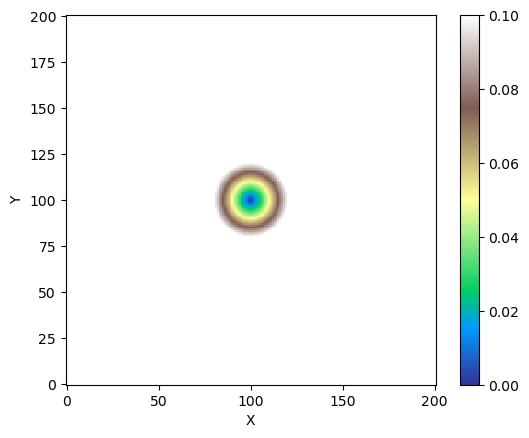

In [3]:
imshow_grid(mg, h, cmap = 'terrain')

In [4]:
#midpoint_z = []
depths = []

areas =[]
times = []
for ts in range(tsteps):

    #Calculate sub-debris melt using an exponential decay model
    melt = b_0 * dt * (h_char/ (h_char + h))
    z -= melt
    h = h.copy() + melt * deb_conc

    #Update the surface topography 
    surf = h + z

    #Calculate the gradient and slope of the topography, map the slope values to the links
    grad = mg.calc_grad_at_link(surf)
    slp = mg.calc_slope_at_node(surf)
    slope = mg.map_mean_of_link_nodes_to_link(slp)
  
    h_link = mg.map_mean_of_link_nodes_to_link(h)

    #Calculate hillslope debris flux using the nonlinear approximation
    #qs[mg.active_links] = D_m_yr * h_link[mg.active_links] * grad[mg.active_links] / (1 - (slope[mg.active_links] / s_c)**2)
    qs[mg.active_links] = D_m_yr * (1 - np.exp(-h_link[mg.active_links] / h_char)) * grad[mg.active_links] / (1 - (slope[mg.active_links]/s_c)**2)


    #Calulate the flux divergence
    dhdt = mg.calc_flux_div_at_node(qs) * dt

    #Update the debris thickness
    h = h.copy() + dhdt

    #Update the surface topography
    surf[mg.core_nodes] = z[mg.core_nodes] + h[mg.core_nodes]
    
    #depression_ids = mg.at_node['depression__id']
    #depression_id = depression_ids[j]
    #depressionAreas[ts] = df2.lake_areas[0]

    #Update all the fields
    mg.at_node['debris_thickness'] = h
    mg.at_node['glacier_surface'] = surf
    mg.at_node['topographic__elevation'] = z
    
    if ts % 2 == 0:
        times.append(ts*dt)
        #midpoint_z.append(z[nr*nc//2 +1] - z.mean())
        year = int(ts*dt)
        df2 = DepressionFinderAndRouter(mg)
        df2.map_depressions()
        #print(df2.lake_areas[0])
        #imshow_grid(mg, surf, cmap = 'terrain', vmin = surf.min(), vmax = surf.max())
        #imshow_grid(mg, df2.lake_at_node, vmin = 0, vmax = 1)
        #plt.show()
        #plt.savefig('figs/no-sinks-depres_' + str(year) + '.png', dpi = 300)
        #plt.close()

        if len(df2.lake_areas) > 0:
            areas.append(df2.lake_areas[0])
            #Calculate depression depth
            outlet_node = df2.lake_outlets[0] 
            outlet_elevation = mg.at_node['topographic__elevation'][outlet_node]
            depth = outlet_elevation - z[nr*nc//2 + 1]
            depths.append(depth)
        else:
            areas.append(0)
            depths.append(0)
        #plt.savefig("../depression-figs/ts_" + str(ts) + ".png", dpi = 200)
        #plt.close()

df = pd.DataFrame()
df['time(y)'] = times
df['mp_elev(m)'] = depths #midpoint_z
df['dep_area(m^2)'] = areas

df.to_csv(fname, index = False)


In [ ]:
#plt.plot(np.arange(0, len(midpoint))*dt, midpoint)
plt.plot(np.arange(0, len(areas)), areas)


In [ ]:
r_list = [10, 20]
D_list = [0.1, 0.25, 0.5, 0.75, 1.]
b_list = [1, 2]

for r in r_list:
    for D in D_list:
        for b_0 in b_list:
            #fname = 'patch_r20_D025_b2.csv'
            Dtmp = str(D)
            Dtmp = Dtmp.replace(".", "")
            fname = 'NS_patch_r' + str(r) + '_D' + Dtmp + '_b' + str(b_0) + '.csv'
            print(fname)
            nr = 201
            nc = 201
            dx = 1.
            mg = RasterModelGrid((nr, nc), xy_spacing = dx)

            z = np.ones(nr*nc) * 100 + mg.y_of_node * 0.01
            z = mg.add_field('topographic__elevation', z, at = 'node')

            # --- Parameters you can adjust ---
            max_thickness = 0.1  # The desired maximum thickness
            center_x = 100        # X-coordinate of the center of the circular pattern
            center_y = 100        # Y-coordinate of the center of the circular pattern
            # This is the new parameter: the radius at which the thickness reaches its maximum.
            # For example, if your grid is 100x100, the maximum possible distance from (50,50) to a corner
            # is about 70.7. If you set target_radius_for_max_thickness to, say, 30.0,
            # the thickness will reach 0.2 at a radius of 30 and stay 0.2 beyond that.
            target_radius_for_max_thickness = r # Adjust this value to decrease/increase the "radius of change"
            # ---------------------------------

            # Calculate the distance of each node from the center (50, 50)
            distances = np.sqrt((mg.x_of_node - center_x)**2 + (mg.y_of_node - center_y)**2)

            # Calculate the scaled thickness:
            # - It increases linearly from 0 at the center to 1.0 at target_radius_for_max_thickness.
            # - It is capped at 1.0, so points beyond target_radius_for_max_thickness also get a scale of 1.0.
            scaled_thickness = np.minimum(distances / target_radius_for_max_thickness, 1.0)

            # Initialize debris_thickness field to zeros
            h = mg.add_zeros('debris_thickness', at='node')

            # Add the calculated thickness
            h += max_thickness * scaled_thickness


            #h = mg.add_zeros('debris_thickness', at = 'node')
            #h += 0.2 * np.sqrt((mg.x_of_node-50)**2 + (mg.y_of_node-50)**2)/(np.sqrt((mg.x_of_node-50)**2 + (mg.y_of_node-50)**2)).max()
            surf = mg.add_zeros('glacier_surface', at = 'node')
            qs = mg.add_zeros('debris_flux', at = 'link')
            melt = mg.add_zeros('melt', at = 'node')

            surf = z + h

            mg.status_at_node[mg.nodes_at_left_edge] = mg.BC_NODE_IS_FIXED_VALUE
            mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE
            mg.status_at_node[mg.nodes_at_bottom_edge] = mg.BC_NODE_IS_FIXED_VALUE
            mg.status_at_node[mg.nodes_at_top_edge] = mg.BC_NODE_IS_FIXED_VALUE


            h_char = 0.08  #Characteristic decay debris thickness
            D_m_yr = D  #Hillslope diffusion constant (needs to be small)

            s_c = 1.15     #Critical slope at which hillslope debris flux goes to infinity
            deb_conc = 0.01

            dt = 0.1
            time_years = 201
            tsteps = int(time_years/dt)
            x_mid = nc//2
            y_mid = nr//2

            depressionAreas = np.zeros(tsteps)

            depths = []

            areas =[]
            times = []
            for ts in range(tsteps):

                #Calculate sub-debris melt using an exponential decay model
                melt = b_0 * dt * (h_char/ (h_char + h))
                z -= melt
                h = h.copy() + melt * deb_conc

                #Update the surface topography 
                surf = h + z

                #Calculate the gradient and slope of the topography, map the slope values to the links
                grad = mg.calc_grad_at_link(surf)
                slp = mg.calc_slope_at_node(surf)
                slope = mg.map_mean_of_link_nodes_to_link(slp)
            
                h_link = mg.map_mean_of_link_nodes_to_link(h)

                #Calculate hillslope debris flux using the nonlinear approximation
                #qs[mg.active_links] = D_m_yr * h_link[mg.active_links] * grad[mg.active_links] / (1 - (slope[mg.active_links] / s_c)**2)
                qs[mg.active_links] = D_m_yr * (1 - np.exp(-h_link[mg.active_links] / h_char)) * grad[mg.active_links] / (1 - (slope[mg.active_links]/s_c)**2)


                #Calulate the flux divergence
                dhdt = mg.calc_flux_div_at_node(qs) * dt

                #Update the debris thickness
                h = h.copy() + dhdt

                #Update the surface topography
                surf[mg.core_nodes] = z[mg.core_nodes] + h[mg.core_nodes]
                
                #depression_ids = mg.at_node['depression__id']
                #depression_id = depression_ids[j]
                #depressionAreas[ts] = df2.lake_areas[0]

                #Update all the fields
                mg.at_node['debris_thickness'] = h
                mg.at_node['glacier_surface'] = surf
                mg.at_node['topographic__elevation'] = z
                
                if ts % 2 == 0:
                    times.append(ts*dt)
                    #midpoint_z.append(z[nr*nc//2 +1] - z.mean())
                    year = int(ts*dt)
                    df2 = DepressionFinderAndRouter(mg)
                    df2.map_depressions()
                    #print(df2.lake_areas[0])
                    #imshow_grid(mg, surf, cmap = 'terrain', vmin = surf.min(), vmax = surf.max())
                    #imshow_grid(mg, df2.lake_at_node, vmin = 0, vmax = 1)
                    #plt.show()
                    #plt.savefig('figs/no-sinks-depres_' + str(year) + '.png', dpi = 300)
                    #plt.close()

                    if len(df2.lake_areas) > 0:
                        areas.append(df2.lake_areas[0])
                        #Calculate depression depth
                        outlet_node = df2.lake_outlets[0] 
                        outlet_elevation = mg.at_node['topographic__elevation'][outlet_node]
                        depth = outlet_elevation - z[nr*nc//2 + 1]
                        depths.append(depth)
                    else:
                        areas.append(0)
                        depths.append(0)

            df = pd.DataFrame()
            df['time(y)'] = times
            df['mp_elev(m)'] = depths #midpoint_z
            df['dep_area(m^2)'] = areas
            df.to_csv(fname, index = False)

NS_patch_r10_D01_b1.csv
NS_patch_r10_D01_b2.csv
NS_patch_r10_D025_b1.csv
NS_patch_r10_D025_b2.csv
NS_patch_r10_D05_b1.csv
NS_patch_r10_D05_b2.csv
NS_patch_r10_D075_b1.csv
NS_patch_r10_D075_b2.csv
NS_patch_r10_D10_b1.csv
NS_patch_r10_D10_b2.csv
NS_patch_r20_D01_b1.csv
NS_patch_r20_D01_b2.csv
NS_patch_r20_D025_b1.csv
NS_patch_r20_D025_b2.csv
NS_patch_r20_D05_b1.csv
NS_patch_r20_D05_b2.csv
NS_patch_r20_D075_b1.csv
NS_patch_r20_D075_b2.csv
NS_patch_r20_D10_b1.csv
NS_patch_r20_D10_b2.csv


In [7]:
x = str(0.25)
x= x.replace('.', '')
x

'025'